In [5]:
from fastai.vision.all import *

In [6]:
Path.BASE_PATH = path = Path.home()/'paddy'
trn_path = path/'train_images'

In [7]:
path.ls()

(#5) [Path('train_images'),Path('train.csv'),Path('sample_submission.csv'),Path('paddy-disease-classification.zip'),Path('test_images')]

In [8]:
trn_path.ls()

(#10) [Path('train_images/bacterial_leaf_streak'),Path('train_images/hispa'),Path('train_images/normal'),Path('train_images/blast'),Path('train_images/dead_heart'),Path('train_images/bacterial_leaf_blight'),Path('train_images/tungro'),Path('train_images/bacterial_panicle_blight'),Path('train_images/brown_spot'),Path('train_images/downy_mildew')]

In [9]:
blb = trn_path/'bacterial_leaf_blight'
blb.ls()

(#479) [Path('train_images/bacterial_leaf_blight/100982.jpg'),Path('train_images/bacterial_leaf_blight/109588.jpg'),Path('train_images/bacterial_leaf_blight/101638.jpg'),Path('train_images/bacterial_leaf_blight/100234.jpg'),Path('train_images/bacterial_leaf_blight/101647.jpg'),Path('train_images/bacterial_leaf_blight/104657.jpg'),Path('train_images/bacterial_leaf_blight/103357.jpg'),Path('train_images/bacterial_leaf_blight/109673.jpg'),Path('train_images/bacterial_leaf_blight/104106.jpg'),Path('train_images/bacterial_leaf_blight/101659.jpg')...]

In [10]:
df = pd.read_csv(path/'train.csv')

In [11]:
df

,image_id,label,variety,age
0,100330.jpg,bacterial_leaf_blight,ADT45,45
1,100365.jpg,bacterial_leaf_blight,ADT45,45
2,100382.jpg,bacterial_leaf_blight,ADT45,45
3,100632.jpg,bacterial_leaf_blight,ADT45,45
4,101918.jpg,bacterial_leaf_blight,ADT45,45
...,...,...,...,...
10402,107607.jpg,tungro,Zonal,55
10403,107811.jpg,tungro,Zonal,55
10404,108547.jpg,tungro,Zonal,55
10405,110245.jpg,tungro,Zonal,55


In [12]:
files = get_image_files(trn_path)
files

(#10407) [Path('train_images/bacterial_leaf_streak/100081.jpg'),Path('train_images/bacterial_leaf_streak/104135.jpg'),Path('train_images/bacterial_leaf_streak/108249.jpg'),Path('train_images/bacterial_leaf_streak/100235.jpg'),Path('train_images/bacterial_leaf_streak/105265.jpg'),Path('train_images/bacterial_leaf_streak/109925.jpg'),Path('train_images/bacterial_leaf_streak/106054.jpg'),Path('train_images/bacterial_leaf_streak/103307.jpg'),Path('train_images/bacterial_leaf_streak/106974.jpg'),Path('train_images/bacterial_leaf_streak/101151.jpg')...]

In [13]:
img = PILImage.create(files[0])

In [14]:
img.size

(480, 640)

In [15]:
def is_cat(x): return x[0].isupper()

In [16]:
dls = ImageDataLoaders.from_folder(trn_path, valid_pct=0.2, item_tfms=Resize(224))

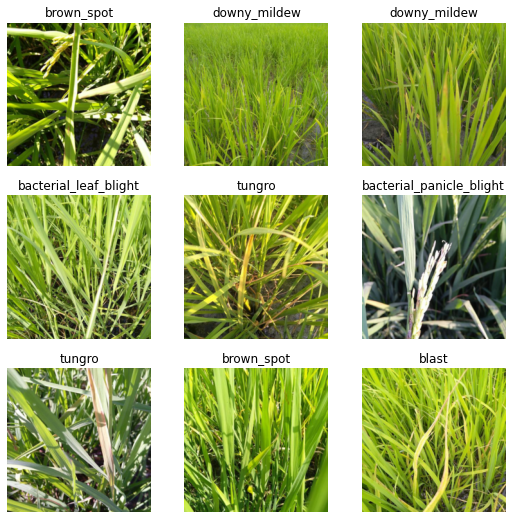

In [17]:
dls.show_batch()

In [18]:
learn = vision_learner(dls, resnet34, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [ ]:
learn.fine_tune(1)

epoch,train_loss,valid_loss,error_rate,time
0,1.968148,1.035647,0.346468,01:22


epoch,train_loss,valid_loss,error_rate,time
